In [223]:
from tensorflow.keras.applications import VGG16
import tensorflow as tf
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os
import random

In [224]:
print("[INFO] loading dataset...")
rows = open('Dataset/airplanes.csv').read().strip().split("\n")

[INFO] loading dataset...


In [225]:
data = []
targets = []
filenames = []

In [226]:
for row in rows:
    # break the row into the filename and bounding box coordinates
    row = row.split(",")
    (filename, startX, startY, endX, endY) = row

    # derive the path to the input image, load the image (in OpenCV
    # format), and grab its dimensions
    imagePath = os.path.sep.join(['./dataset/images', filename])
    image = cv2.imread(imagePath)
    (h, w) = image.shape[:2]

    # scale the bounding box coordinates relative to the spatial
    # dimensions of the input image
    startX = float(startX) / w
    startY = float(startY) / h
    endX = float(endX) / w
    endY = float(endY) / h

    # load the image and preprocess it
    image = load_img(imagePath, target_size=(224, 224))
    image = img_to_array(image)

    # update our list of data, targets, and filenames
    data.append(image)
    targets.append((startX, startY, endX, endY))
    filenames.append(filename)

In [227]:
data = np.array(data, dtype="float32") / 255.0
targets = np.array(targets, dtype="float32")

In [228]:
split = train_test_split(data, targets, filenames, test_size=0.10,random_state=42)

In [229]:
(trainImages, testImages) = split[:2]
(trainTargets, testTargets) = split[2:4]
(trainFilenames, testFilenames) = split[4:]

In [230]:
INIT_LR = 1e-4
NUM_EPOCHS = 25
BATCH_SIZE = 32
vgg = VGG16(weights="imagenet", include_top=False,input_tensor=Input(shape=(224, 224, 3)))
#freeze all VGG layers so they will *not* be updated during the training process
vgg.trainable = False

# flatten the max-pooling output of VGG
flatten = vgg.output
flatten = Flatten()(flatten)

# construct a fully-connected layer header to output the predicted
# bounding box coordinates
bboxHead = Dense(128, activation="relu")(flatten)
bboxHead = Dense(64, activation="relu")(bboxHead)
bboxHead = Dense(32, activation="relu")(bboxHead)
bboxHead = Dense(4, activation="sigmoid")(bboxHead)

# construct the model we will fine-tune for bounding box regression
model = Model(inputs=vgg.input, outputs=bboxHead)

# initialize the optimizer, compile the model, and show the model
# summary
opt = Adam(INIT_LR)
model.compile(loss="mse", optimizer=Adam(learning_rate= INIT_LR))
print(model.summary())

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

In [85]:
checkpointPath = 'train_model'

In [72]:
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath = checkpointPath + 'best.h5', monitor = 'val_loss', mode = 'max', save_best_only = True)

In [87]:
print("[INFO] training bounding box regressor...")
H = model.fit(
    trainImages, trainTargets,
    validation_data=(testImages, testTargets),
    batch_size=BATCH_SIZE,
    epochs=NUM_EPOCHS,
    verbose=1,
   callbacks = [model_checkpoint_callback])

[INFO] training bounding box regressor...
Train on 720 samples, validate on 80 samples
Epoch 1/25
 32/720 [>.............................] - ETA: 3:52 - loss: 0.0954

KeyboardInterrupt: 

In [231]:
model.load_weights('train_modelbest.h5')

In [172]:
# serialize the model to disk
print("[INFO] saving object detector model...")
model.save(MODEL_PATH,save_format="h5")

[INFO] saving object detector model...


In [37]:
N = 25
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.title("Bounding Box Regression Loss on Training Set")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend(loc="lower left")

In [232]:
def predict_bounding_box(image_path):
    image = load_img(image_path, target_size=(224, 224))
    image = img_to_array(image) / 255.0
    #plt.imshow(image)
    image = np.expand_dims(image, axis=0)

    # make bounding box predictions on the input image
    preds = model.predict(image)[0]
    (startX, startY, endX, endY) = preds

    # load the input image (in OpenCV format), resize it such that it
    # fits on our screen, and grab its dimensions
    image = cv2.imread(image_path)
    image = imutils.resize(image, width=600)
    (h, w) = image.shape[:2]

    # scale the predicted bounding box coordinates based on the image
    # dimensions
    startX = int(startX * w)
    startY = int(startY * h)
    endX = int(endX * w)
    endY = int(endY * h)

    # draw the predicted bounding box on the image
    cv2.rectangle(image, (startX, startY), (endX, endY),
    (0, 255, 0), 2)
    return image
    # show the output image
#     cv2.imshow("Output", image)
#     cv2.waitKey(0)

In [233]:
test_images = []
with open('./output/test_images.txt') as test_img:
    lines = test_img.readlines()
for line in lines:
    test_images.append(line.strip())

dataset/images/image_0580.jpg


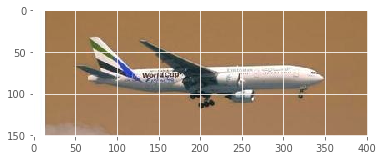

In [297]:
img_path = 'dataset/images'
img = random.sample(test_images,1)
print(img_path+'/'+img[0])
image = cv2.imread(img_path+'/'+img[0])
plt.imshow(image)

In [298]:
print(img_path+'/'+img[0])
pred_image = predict_bounding_box(img_path+'/'+img[0])

dataset/images/image_0580.jpg


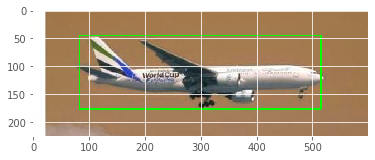

In [299]:
plt.imshow(pred_image)